In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Project Challenges

In this project, we aim to address the following challenges:

1. **Image Preprocessing:** Preprocessing the facial images is crucial for the success of the model. This includes resizing, normalizing, and converting images to a format suitable for neural networks. Ensuring the input data is appropriately prepared is essential.

2. **Model Architecture:** Designing an effective neural network architecture that can handle both age regression and gender classification tasks simultaneously is a non-trivial task. Balancing the model's complexity while maintaining good performance is essential.

3. **Gender Classification:** Another significant challenge is to classify the gender of a person from their facial image. The model must learn to distinguish between male and female characteristics, often requiring subtle visual cues.

4. **Age Estimation:** The primary challenge is to develop a model that can accurately estimate the age of a person based on their facial features. This involves training a deep learning model to regress the age of individuals, which can be a complex and nuanced task.

5. **Hyperparameter Tuning:** Finding the right set of hyperparameters for training the model can significantly impact its performance. It involves optimizing learning rates, batch sizes, regularization techniques, and more.

6. **Evaluation Metrics:** Choosing appropriate evaluation metrics for age estimation and gender classification is vital. Mean Absolute Error (MAE) for age regression and accuracy for gender classification are common metrics, but others may be considered.

7. **Data Quality and Quantity:** The quality and quantity of the dataset play a significant role in the model's performance. Ensuring a diverse and representative dataset can be challenging, and data augmentation techniques may be required.

8. **Interpreting Model Predictions:** Understanding how the model arrives at its predictions is crucial, especially in applications like age estimation and gender classification. Visualizing model explanations and uncertainty can be a challenge.

By addressing these challenges, we aim to create a robust and accurate system for estimating the age and gender of individuals from facial images.


# Importing Libraries

In [1]:
!pip install --upgrade pip
!pip install seaborn
!pip install Pillow
!pip install imgaug
!pip install opencv-python
!apt-get update
!apt-get install -y libgl1-mesa-glx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 11.2 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for scikit-image>=0.14.2 from https://files.pythonhosted.org/packages/33/29/1d696450464d6e13358d3ef185a1fb14a11181c5dab1eb2837c02be86373/scikit_image-0.21.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/b7/8a/b2f7e1a434d56bf1d7570fc5941

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import load_img
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import numpy as np
import random
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import imgaug.augmenters as iaa

import os
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

D1008 23:26:35.706750800      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1008 23:26:35.706775643      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1008 23:26:35.706779515      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1008 23:26:35.706782596      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1008 23:26:35.706785005      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1008 23:26:35.706787815      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1008 23:26:35.706795439      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1008 23:26:35.

In [3]:
# Configura la estrategia de la TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# Data Labeling

In [4]:
path = '/kaggle/input/utkface-new/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(path)
random.shuffle(image_filenames)

for image in image_filenames:
    image_path = os.path.join(path, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])
    
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)

In [5]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [6]:
print(age_labels[:10])
print(gender_labels[:10])
print(image_paths[:10])

[80, 34, 26, 29, 24, 48, 26, 26, 35, 26]
[0, 1, 1, 1, 1, 0, 0, 1, 1, 1]
['/kaggle/input/utkface-new/UTKFace/80_0_0_20170111201430389.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/34_1_0_20170119170609560.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/26_1_2_20170116182218057.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/29_1_1_20170116195846538.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/24_1_1_20170116222611638.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/48_0_1_20170113183822367.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/26_0_0_20170116224830372.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/26_1_3_20170117174313937.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/35_1_0_20170103182733994.jpg.chip.jpg', '/kaggle/input/utkface-new/UTKFace/26_1_3_20170119193137209.jpg.chip.jpg']


In [7]:
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(10)

,image_path,age,gender
0,/kaggle/input/utkface-new/UTKFace/80_0_0_20170...,80,0
1,/kaggle/input/utkface-new/UTKFace/34_1_0_20170...,34,1
2,/kaggle/input/utkface-new/UTKFace/26_1_2_20170...,26,1
3,/kaggle/input/utkface-new/UTKFace/29_1_1_20170...,29,1
4,/kaggle/input/utkface-new/UTKFace/24_1_1_20170...,24,1
5,/kaggle/input/utkface-new/UTKFace/48_0_1_20170...,48,0
6,/kaggle/input/utkface-new/UTKFace/26_0_0_20170...,26,0
7,/kaggle/input/utkface-new/UTKFace/26_1_3_20170...,26,1
8,/kaggle/input/utkface-new/UTKFace/35_1_0_20170...,35,1
9,/kaggle/input/utkface-new/UTKFace/26_1_3_20170...,26,1


# Distributions

<Axes: xlabel='age', ylabel='Density'>

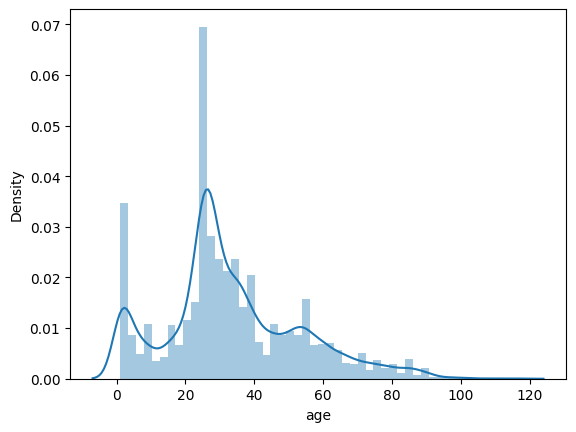

In [8]:
 sns.distplot(df['age'])

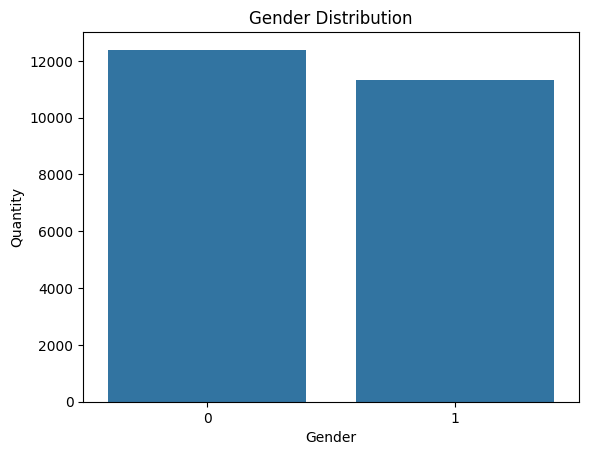

In [9]:
sns.countplot(data=df, x='gender')

plt.xlabel('Gender')
plt.ylabel('Quantity')
plt.title('Gender Distribution')

plt.show()

# Data Augmentation

In [10]:
def apply_data_augmentation(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-10, 10)),  
        iaa.Fliplr(0.9),  
        iaa.Sometimes(0.7, iaa.GaussianBlur(sigma=(0, 2.0))), 
        iaa.Sometimes(0.6, iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255))),  
        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),  
    ])
    
    augmented_img = seq(image=img)
    return augmented_img

selected_images = df[(df['age'] >= 5) & (df['age'] <= 20) | (df['age'] >= 40) & (df['age'] <= 90)]

augmented_images = []
for image_path in selected_images['image_path']:
    augmented_img = apply_data_augmentation(image_path)
    augmented_images.append(augmented_img)

augmented_image_paths = []

augmented_age_labels = []
augmented_gender_labels = []


############
output_directory = '/kaggle/working/augmented_images'  ##### Change this to the desired location
os.makedirs(output_directory, exist_ok=True)
############

for image_path, age_label, gender_label, augmented_img in zip(selected_images['image_path'], selected_images['age'], selected_images['gender'], augmented_images):
    augmented_image_filename = os.path.basename(image_path).replace('.jpg', '_augmented.jpg')
    augmented_image_path = os.path.join(output_directory, augmented_image_filename)
    
    augmented_image_paths.append(augmented_image_path)
    
    augmented_age_labels.append(age_label)
    augmented_gender_labels.append(gender_label)
    
    plt.imsave(augmented_image_path, augmented_img.astype(np.uint8))

print(f"Número de imágenes originales: {len(selected_images)}")
print(f"Número de imágenes aumentadas: {len(augmented_images)}")

augmented_df = pd.DataFrame()
augmented_df['image_path'] = augmented_image_paths
augmented_df['age'] = augmented_age_labels
augmented_df['gender'] = augmented_gender_labels

Número de imágenes originales: 9857
Número de imágenes aumentadas: 9857


In [11]:
combined_df = pd.concat([df, augmented_df], ignore_index=True)

In [12]:
combined_df

,image_path,age,gender
0,/kaggle/input/utkface-new/UTKFace/80_0_0_20170...,80,0
1,/kaggle/input/utkface-new/UTKFace/34_1_0_20170...,34,1
2,/kaggle/input/utkface-new/UTKFace/26_1_2_20170...,26,1
3,/kaggle/input/utkface-new/UTKFace/29_1_1_20170...,29,1
4,/kaggle/input/utkface-new/UTKFace/24_1_1_20170...,24,1
...,...,...,...
33560,/kaggle/working/augmented_images/12_1_0_201701...,12,1
33561,/kaggle/working/augmented_images/55_1_3_201701...,55,1
33562,/kaggle/working/augmented_images/5_1_0_2017010...,5,1
33563,/kaggle/working/augmented_images/47_0_3_201701...,47,0


#### **BEFORE**

<Axes: xlabel='age', ylabel='Density'>

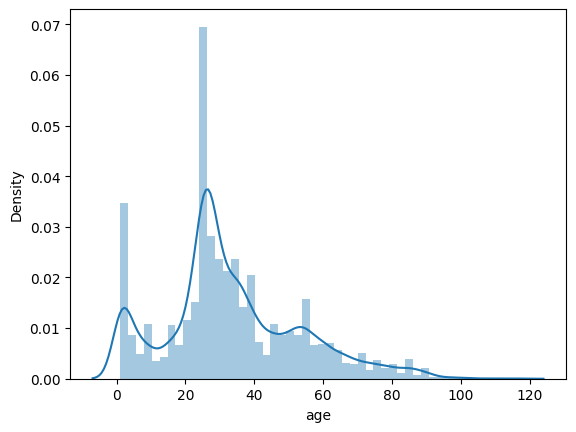

In [13]:
sns.distplot(df['age'])

#### **AFTER**

<Axes: xlabel='age', ylabel='Density'>

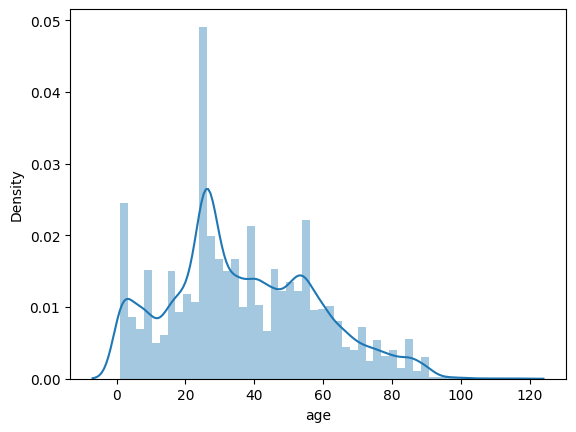

In [14]:
sns.distplot(combined_df['age'])

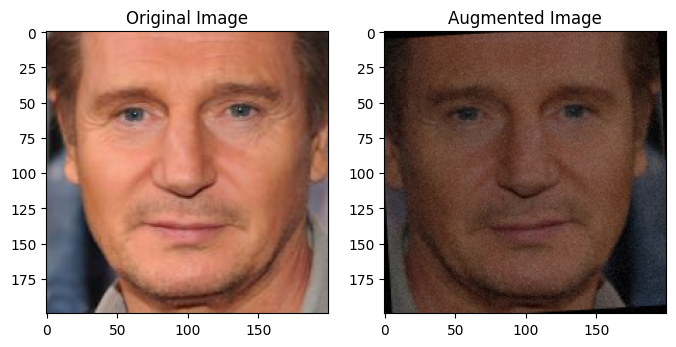

In [15]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
img = load_img(selected_images.iloc[3]['image_path'])
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title("Augmented Image")
augmented_img = augmented_images[3]
augmented_img = np.clip(augmented_img, 0, 255).astype(np.uint8)  
plt.imshow(augmented_img)
plt.show()

# Preprocessing

In [16]:
def extract_image_features(images):
    features = list()

    for image in images:
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [17]:
filtered_df = combined_df[combined_df['age'] < 60]

X = extract_image_features(filtered_df['image_path'])

X = X / 255.0

X.shape

(28272, 128, 128, 1)

In [18]:
y_gender = np.array(filtered_df['gender'])
y_age = np.array(filtered_df['age'])

In [19]:
X_rgb = np.repeat(X, 3, axis=-1)

X_rgb = X_rgb * 255

def resize_images(images):
    resized_images = []
    for image in images:
        img = cv2.resize(image, (224, 224))
        resized_images.append(img)
    return np.array(resized_images)

X_rgb = resize_images(X_rgb)

X_rgb = X_rgb / 255.0

X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(X_rgb, y_gender, y_age, test_size=0.2, random_state=42)

# Building and fitting models

In [20]:
def create_gender_model(learning_rate=0.001, dropout_rate=0.5, optimizer='adam', kernel_size=(3, 3), pool_size=(2, 2)):
    input_shape = (224, 224, 3)
    with strategy.scope():
        inputs = Input(shape=input_shape)
        
        conv_1 = Conv2D(64, kernel_size=kernel_size, activation='relu')(inputs)
        max_1 = MaxPooling2D(pool_size=pool_size)(conv_1)
        conv_2 = Conv2D(128, kernel_size=kernel_size, activation='relu')(max_1)
        max_2 = MaxPooling2D(pool_size=pool_size)(conv_2)
        conv_3 = Conv2D(256, kernel_size=kernel_size, activation='relu')(max_2)
        max_3 = MaxPooling2D(pool_size=pool_size)(conv_3)
        conv_4 = Conv2D(512, kernel_size=kernel_size, activation='relu')(max_3)
        max_4 = MaxPooling2D(pool_size=pool_size)(conv_4)

        flatten = Flatten()(max_4)
        dense_1 = Dense(512, activation='relu')(flatten)
        dropout_1 = Dropout(dropout_rate)(dense_1)
        dense_2 = Dense(256, activation='relu')(dropout_1)
        dropout_2 = Dropout(dropout_rate)(dense_2)
        
        output_gender = Dense(1, activation='sigmoid', name='gender_out')(dropout_2)
        
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            optimizer = SGD(learning_rate=learning_rate)
            
        gender_model = Model(inputs=inputs, outputs=output_gender)
        gender_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return gender_model

def create_age_model(learning_rate=0.001, dropout_rate=0.3, optimizer='adam', kernel_size=(3, 3), pool_size=(2, 2)):
    input_shape = (224, 224, 3)
    with strategy.scope():
        inputs = Input(shape=input_shape)
        
        conv_1 = Conv2D(64, kernel_size=kernel_size, activation='relu')(inputs)
        max_1 = MaxPooling2D(pool_size=pool_size)(conv_1)
        conv_2 = Conv2D(128, kernel_size=kernel_size, activation='relu')(max_1)
        max_2 = MaxPooling2D(pool_size=pool_size)(conv_2)
        conv_3 = Conv2D(256, kernel_size=kernel_size, activation='relu')(max_2)
        max_3 = MaxPooling2D(pool_size=pool_size)(conv_3)
        conv_4 = Conv2D(512, kernel_size=kernel_size, activation='relu')(max_3)
        max_4 = MaxPooling2D(pool_size=pool_size)(conv_4)

        flatten = Flatten()(max_4)
        dense_1 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(flatten)
        dropout_1 = Dropout(dropout_rate)(dense_1)
        dense_2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)
        dropout_2 = Dropout(dropout_rate)(dense_2)
        dense_3 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dropout_2)
        
        output_age = Dense(1, activation='linear', name='age_out')(dense_3)
        
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            optimizer = SGD(learning_rate=learning_rate)
        
        age_model = Model(inputs=inputs, outputs=output_age)
        age_model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])
    return age_model

gender_model = KerasClassifier(build_fn=create_gender_model, verbose=0)
age_model = KerasRegressor(build_fn=create_age_model, verbose=0)

param_grid_gender = {
    'learning_rate': [0.0001, 0.00001],
    'dropout_rate': [0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'kernel_size': [(3, 3), (4, 4)],
    'pool_size': [(2, 2), (3, 3)]
}

param_grid_age = {
    'learning_rate': [0.0001, 0.00001],
    'dropout_rate': [0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'kernel_size': [(3, 3), (4, 4)],
    'pool_size': [(2, 2), (3, 3)]
}

grid_gender = GridSearchCV(estimator=gender_model, param_grid=param_grid_gender, cv=3, verbose=2)
grid_gender_result = grid_gender.fit(X_train, y_gender_train)

grid_age = GridSearchCV(estimator=age_model, param_grid=param_grid_age, cv=3, verbose=2)
grid_age_result = grid_age.fit(X_train, y_age_train)

print("Mejores Hiperparámetros para Género: ", grid_gender_result.best_params_)
print("Mejor Puntaje para Género: ", grid_gender_result.best_score_)

print("Mejores Hiperparámetros para Edad: ", grid_age_result.best_params_)
print("Mejor Puntaje para Edad: ", -grid_age_result.best_score_)  # We use the negative of the score since KerasRegressor minimizes the error

Fitting 3 folds for each of 48 candidates, totalling 144 fits


2023-10-03 14:46:42.282030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:46:42.408756: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:47:25.220221: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:47:25.315309: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 14:48:13.985378: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:48:14.112617: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:48:53.648935: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:48:53.743816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 14:49:42.149292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:49:42.272619: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:50:21.468116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:50:21.564729: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 14:51:12.788626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:51:12.925155: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:51:42.147584: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:51:42.243129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 14:52:24.018697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:52:24.140973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:52:53.741228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:52:53.836247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 14:53:38.530372: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:53:38.656125: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:54:07.960622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:54:08.061127: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 14:54:50.108112: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:54:50.227731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:55:28.954420: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:55:29.049535: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 14:56:20.948521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:56:21.075516: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:56:59.947931: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:57:00.056967: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 14:57:48.269186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:57:48.382968: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:58:26.814795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:58:26.920746: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.4min


2023-10-03 14:59:19.245741: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:59:19.388534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:59:48.377245: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 14:59:48.485442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 15:00:30.779034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:00:30.898892: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:00:59.901465: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:01:00.002767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 15:01:41.277761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:01:41.400194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:02:14.770089: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:02:14.901098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 15:02:56.922690: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:02:57.060559: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:03:36.151353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:03:36.248636: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:04:24.891816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:04:25.024762: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:05:04.731795: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:05:04.838771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:06:00.377651: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:06:00.515097: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:06:39.858393: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:06:39.960973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 15:07:28.618405: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:07:28.748695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:07:58.182540: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:07:58.279288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 15:08:44.045438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:08:44.191246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:09:13.780042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:09:13.886190: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 15:09:56.688898: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:09:56.820711: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:10:25.679146: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:10:25.774999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 15:11:12.516485: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:11:12.663468: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:11:51.781404: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:11:51.900089: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:12:40.159631: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:12:40.274764: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:13:19.946326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:13:20.054310: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:14:09.300797: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:14:09.412968: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:14:52.134717: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:14:52.269634: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:15:39.903978: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:15:40.025525: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:16:09.138763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:16:09.242852: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 15:16:50.602955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:16:50.726465: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:17:20.140775: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:17:20.236798: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 15:18:05.136868: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:18:05.272410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:18:34.680769: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:18:34.784684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 15:19:18.832404: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:19:18.966945: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:20:00.466472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:20:00.566174: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:20:54.632776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:20:54.791129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:21:36.287792: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:21:36.389884: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 15:22:24.159491: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:22:24.283815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:23:04.426688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:23:04.522597: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:23:55.603603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:23:55.787459: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:24:28.114246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:24:28.224639: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 15:25:11.933615: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:25:12.058120: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:25:43.665827: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:25:43.768327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 15:26:31.039132: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:26:31.204785: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:27:03.623777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:27:03.731325: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.4min


2023-10-03 15:27:49.724426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:27:49.838724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:28:29.681288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:28:29.789222: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:29:20.307329: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:29:20.489319: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:30:01.725407: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:30:01.858932: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:30:50.364427: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:30:50.481322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:31:30.335138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:31:30.431706: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:32:25.218111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:32:25.330073: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:33:01.654918: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:33:01.808959: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.5min


2023-10-03 15:33:45.688141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:33:45.815074: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:34:16.925073: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:34:17.030710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 15:35:01.539697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:35:01.652991: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:35:33.577051: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:35:33.674693: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 15:36:25.687612: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:36:25.857475: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:37:06.892192: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:37:07.001654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 15:37:55.346141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:37:55.469388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:38:36.617148: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:38:36.712891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:39:33.972526: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:39:34.154697: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:40:16.436771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:40:16.556722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.7min


2023-10-03 15:41:03.786685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:41:03.911177: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:41:35.903699: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:41:36.000874: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 15:42:19.985338: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:42:20.105940: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:42:56.429097: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:42:56.578932: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 15:43:41.531415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:43:41.663273: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:44:13.468711: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:44:13.566627: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 15:44:56.848626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:44:56.964488: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:45:37.439478: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:45:37.536379: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:46:29.202886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:46:29.334303: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:47:10.075588: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:47:10.180964: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:47:57.758267: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:47:57.870542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:48:37.918010: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:48:38.016822: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:49:27.475656: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:49:27.633735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:49:59.095504: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:49:59.203440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 15:50:42.869382: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:50:42.997648: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:51:14.458460: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:51:14.554451: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 15:52:01.807610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:52:01.971259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:52:34.288787: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:52:34.410358: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 15:53:22.563424: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:53:22.692317: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:54:02.003655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:54:02.098642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:54:59.988843: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:55:00.117818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:55:46.132936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:55:46.264622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.7min


2023-10-03 15:56:35.128076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:56:35.263974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:57:15.064285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:57:15.173801: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 15:58:03.148590: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:58:03.275931: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:58:36.063950: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:58:36.216586: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 15:59:17.837230: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:59:17.976836: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:59:47.626414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 15:59:47.724783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 16:00:29.644136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:00:29.766088: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:00:59.557695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:00:59.654886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 16:02:00.188703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:02:00.327075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:02:39.634789: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:02:39.756576: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.8min


2023-10-03 16:03:28.708326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:03:28.822204: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:04:08.164748: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:04:08.262921: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:05:02.421769: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:05:02.581041: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:05:42.392176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:05:42.508835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.6min


2023-10-03 16:06:30.287214: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:06:30.405671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:06:59.575049: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:06:59.674369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 16:07:50.159047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:07:50.271246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:08:23.760902: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:08:23.912327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.4min


2023-10-03 16:09:06.061468: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:09:06.190165: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:09:35.595253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:09:35.697075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 16:10:19.375227: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:10:19.498172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:10:59.004567: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:10:59.100398: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:11:52.712041: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:11:52.857894: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:12:32.393034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:12:32.500433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:13:21.274936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:13:21.400215: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:14:01.288893: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:14:01.383890: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:14:55.211329: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:14:55.362292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:15:25.555934: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:15:25.661440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 16:16:07.816816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:16:07.940851: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:16:38.116799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:16:38.214131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 16:17:24.081626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:17:24.246604: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:17:54.342110: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:17:54.450031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 16:18:39.622154: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:18:39.736103: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:19:18.959621: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:19:19.055312: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:20:11.150595: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:20:11.328481: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:20:51.030812: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:20:51.154564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:21:40.336743: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:21:40.454841: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:22:19.531195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:22:19.630115: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:23:10.860776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:23:10.982291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:23:44.955022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:23:45.118586: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 16:24:26.751006: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:24:26.879421: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:24:56.081847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:24:56.181273: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 16:25:40.435297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:25:40.558412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:26:09.444737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:26:09.542076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 16:26:55.719805: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:26:55.892202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:27:37.804696: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:27:37.912775: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 16:28:28.054298: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:28:28.179398: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:29:10.158602: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:29:10.254707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:30:02.036218: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:30:02.205547: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:30:43.689773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:30:43.800224: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 16:31:32.406654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:31:32.532269: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:32:04.949288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:32:05.050828: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 16:32:56.379412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:32:56.567285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:33:28.993391: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:33:29.109260: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.4min


2023-10-03 16:34:15.627496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:34:15.750779: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:34:48.481938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:34:48.587438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 16:35:32.777149: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:35:32.888872: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:36:19.223055: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:36:19.376973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.6min


2023-10-03 16:37:07.489241: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:37:07.617167: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:37:47.941273: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:37:48.054918: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:38:38.182688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:38:38.304840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:39:18.684223: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:39:18.780678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:40:13.869272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:40:14.016537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:40:45.961198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:40:46.067802: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.4min


2023-10-03 16:41:32.945719: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:41:33.059612: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:42:05.208796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:42:05.304591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 16:43:00.545486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:43:00.694528: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:43:33.611024: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:43:33.725421: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.5min


2023-10-03 16:44:19.587717: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:44:19.710502: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:45:01.060348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:45:01.154727: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:45:58.257703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:45:58.440152: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:46:40.338470: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:46:40.450703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 16:47:32.823941: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:47:32.956672: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:48:14.686678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:48:14.789866: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 16:49:10.109546: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:49:10.296741: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:49:43.793891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:49:43.925293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.4min


2023-10-03 16:50:31.002084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:50:31.128734: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:51:03.434029: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:51:03.538478: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 16:51:46.813370: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:51:46.937388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:52:23.237974: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:52:23.382276: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.4min


2023-10-03 16:53:08.716389: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:53:08.851584: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:53:49.563674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:53:49.672733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:54:38.000209: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:54:38.115133: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:55:18.446663: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:55:18.541238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 16:56:13.737048: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:56:13.883711: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:56:55.454569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:56:55.565531: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.6min


2023-10-03 16:57:42.977404: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:57:43.092881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:58:15.185480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:58:15.281277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 16:59:02.955667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:59:03.132631: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:59:35.436772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 16:59:35.559180: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 17:00:18.983550: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:00:19.103455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:00:51.608782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:00:51.705185: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.4, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 17:01:37.566724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:01:37.704154: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:02:22.267680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:02:22.412776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 17:03:15.458379: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:03:15.591388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:03:55.502178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:03:55.600203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 17:04:46.487951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:04:46.615786: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:05:26.884341: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:05:26.984043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:06:18.658706: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:06:18.806452: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:06:48.787286: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:06:48.890627: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 17:07:30.804259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:07:30.928137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:08:00.185069: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:08:00.281144: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 17:08:53.094061: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:08:53.239278: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:09:23.653707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:09:23.759297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.4min


2023-10-03 17:10:07.689239: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:10:07.804086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:10:47.126160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:10:47.222217: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:11:44.615834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:11:44.760472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:12:23.825882: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:12:23.933797: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.6min


2023-10-03 17:13:16.534456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:13:16.652032: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:13:56.442891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:13:56.538802: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:14:55.171281: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:14:55.349296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:15:25.005583: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:15:25.125804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.4min


2023-10-03 17:16:07.496002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:16:07.613224: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:16:37.953243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:16:38.056029: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 17:17:21.009131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:17:21.122948: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:17:55.179184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:17:55.342014: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 17:18:40.399296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:18:40.548057: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:19:20.932835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:19:21.030696: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:20:13.081466: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:20:13.230252: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:20:56.579275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:20:56.675599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 17:21:54.196536: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:21:54.338488: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:22:33.810672: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:22:33.919350: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 17:23:26.474400: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:23:26.598323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:23:56.525819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:23:56.619429: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 17:24:50.742363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:24:50.891412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:25:21.386188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:25:21.488922: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.4min


2023-10-03 17:26:05.074137: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:26:05.203437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:26:35.470738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:26:35.566847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.2min


2023-10-03 17:27:21.690969: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:27:21.842065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:28:00.705177: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:28:00.818344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:28:52.887889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:28:53.014537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:29:31.704864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:29:31.802462: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:30:24.396365: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:30:24.560360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:31:04.839864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:31:04.959525: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:31:55.076324: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:31:55.207814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:32:24.531283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:32:24.630723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 17:33:09.298763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:33:09.417043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:33:43.430262: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:33:43.584675: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 17:34:25.473044: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:34:25.606322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:34:54.802329: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:34:54.906940: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(3, 3), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.2min


2023-10-03 17:35:37.442170: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:35:37.565996: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:36:18.683796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:36:18.781997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:37:14.949231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:37:15.103041: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:37:57.262363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:37:57.374184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.7min


2023-10-03 17:38:46.542560: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:38:46.667053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:39:28.630806: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:39:28.739083: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:40:20.628430: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:40:20.776614: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:40:54.021772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:40:54.128494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.4min


2023-10-03 17:41:49.621133: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:41:49.750032: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:42:22.694539: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:42:22.795049: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.5min


2023-10-03 17:43:10.320334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:43:10.486116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:43:43.308095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:43:43.413517: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 17:44:34.399119: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:44:34.513113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:45:15.552914: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:45:15.648037: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.6min


2023-10-03 17:46:06.471713: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:46:06.676989: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:46:47.882461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:46:48.021196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:47:35.457036: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:47:35.583844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:48:16.115529: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:48:16.218126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 17:49:08.451095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:49:08.564363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:49:45.248844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:49:45.396021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.4min


2023-10-03 17:50:32.686000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:50:32.813317: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:51:04.921930: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:51:05.023724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 17:51:53.211257: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:51:53.338101: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:52:25.233808: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:52:25.328643: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=0.0001, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 17:53:14.056442: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:53:14.215706: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:53:56.446134: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:53:56.557762: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 17:54:49.307060: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:54:49.429188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:55:31.632656: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:55:31.726878: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 17:56:24.308661: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:56:24.479045: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:57:06.813142: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:57:06.928603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 17:57:55.628409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:57:55.752149: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:58:28.430690: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:58:28.526246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 17:59:22.898394: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:59:23.063819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:59:56.300511: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 17:59:56.411450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.5min


2023-10-03 18:00:42.142150: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:00:42.274202: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:01:15.452863: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:01:15.548042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=adam, pool_size=(3, 3); total time= 1.3min


2023-10-03 18:02:03.374698: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:02:03.547928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:02:44.410164: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:02:44.529145: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 18:03:33.042338: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:03:33.159798: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:04:14.301389: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:04:14.396650: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.5min


2023-10-03 18:05:02.941938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:05:03.054651: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:05:48.703844: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:05:48.854960: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(2, 2); total time= 1.6min


2023-10-03 18:06:37.179309: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:06:37.325153: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:07:08.977637: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:07:09.079688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 18:07:55.045393: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:07:55.159316: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:08:28.205439: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:08:28.301011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 18:09:15.908450: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:09:16.050676: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:09:48.210237: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:09:48.319371: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.5, kernel_size=(4, 4), learning_rate=1e-05, optimizer=rmsprop, pool_size=(3, 3); total time= 1.3min


2023-10-03 18:10:27.951375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:10:28.091969: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Fitting 3 folds for each of 48 candidates, totalling 144 fits


2023-10-03 18:11:30.926895: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:11:31.110288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:12:12.344502: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:12:12.463419: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


[CV] END dropout_rate=0.3, kernel_size=(3, 3), learning_rate=0.0001, optimizer=adam, pool_size=(2, 2); total time= 1.6min


2023-10-03 18:13:04.519727: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-03 18:13:04.647859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


KeyboardInterrupt: 

In [21]:
input_shape = (224, 224, 3)

with strategy.scope():

    inputs = Input(shape=input_shape)

    # Convolution and max-pooling layers
    conv_1 = Conv2D(64, kernel_size=(4, 4), activation='relu')(inputs)
    max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = Conv2D(128, kernel_size=(4, 4), activation='relu')(max_1)
    max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = Conv2D(256, kernel_size=(4, 4), activation='relu')(max_2)
    max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
    conv_4 = Conv2D(512, kernel_size=(4, 4), activation='relu')(max_3)
    max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

    # Flattening and fully connected layers with L2 regularization
    flatten = Flatten()(max_4)
    dense_1 = Dense(512, activation='relu')(flatten)
    dropout_1 = Dropout(0.3)(dense_1)
    dense_2 = Dense(256, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.3)(dense_2)
    output_gender = Dense(1, activation='sigmoid', name='gender_out')(dropout_2)

    gender_model = Model(inputs=inputs, outputs=output_gender)
    gender_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


    

    inputs = Input(shape=input_shape)

    # Convolution and max-pooling layers
    conv_1 = Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
    max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_1)
    max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
    conv_3 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_2)
    max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
    conv_4 = Conv2D(512, kernel_size=(3, 3), activation='relu')(max_3)
    max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

    # Flattening and fully connected layers
    flatten = Flatten()(max_4)
    dense_1 = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(flatten)
    dropout_1 = Dropout(0.3)(dense_1)
    dense_2 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(dropout_1)
    dropout_2 = Dropout(0.3)(dense_2)
    dense_3 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dropout_2)
    output_age = Dense(1, activation='linear', name='age_out')(dense_3)

    age_model = Model(inputs=inputs, outputs=output_age)
    age_model.compile(loss='mean_absolute_error', optimizer=RMSprop(learning_rate=0.0001), metrics=['mae'])

    
    
    
    gender_history = gender_model.fit(X_train, y_gender_train, epochs=5, batch_size=32, validation_split=0.2)
    age_history = age_model.fit(X_train, y_age_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/5


2023-10-08 23:33:19.959763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-08 23:33:20.090162: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


566/566 [==============================] - ETA: 0s - loss: 0.4761 - accuracy: 0.7577

2023-10-08 23:33:55.430420: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-08 23:33:55.525593: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


566/566 [==============================] - 49s 69ms/step - loss: 0.4761 - accuracy: 0.7577 - val_loss: 0.3391 - val_accuracy: 0.8450
Epoch 2/5
566/566 [==============================] - 18s 33ms/step - loss: 0.3346 - accuracy: 0.8492 - val_loss: 0.3024 - val_accuracy: 0.8674
Epoch 3/5
566/566 [==============================] - 18s 33ms/step - loss: 0.2853 - accuracy: 0.8774 - val_loss: 0.2661 - val_accuracy: 0.8840
Epoch 4/5
566/566 [==============================] - 18s 32ms/step - loss: 0.2490 - accuracy: 0.8938 - val_loss: 0.2603 - val_accuracy: 0.8870
Epoch 5/5
566/566 [==============================] - 18s 32ms/step - loss: 0.2123 - accuracy: 0.9125 - val_loss: 0.2447 - val_accuracy: 0.8961
Epoch 1/20


2023-10-08 23:35:41.437659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-08 23:35:41.557870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


566/566 [==============================] - ETA: 0s - loss: 19.7213 - mae: 14.5548

2023-10-08 23:36:14.288746: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-08 23:36:14.385799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


566/566 [==============================] - 46s 64ms/step - loss: 19.7213 - mae: 14.5548 - val_loss: 14.2643 - val_mae: 11.9209
Epoch 2/20
566/566 [==============================] - 18s 32ms/step - loss: 13.6862 - mae: 11.7803 - val_loss: 13.2543 - val_mae: 11.6102
Epoch 3/20
566/566 [==============================] - 18s 32ms/step - loss: 12.0497 - mae: 10.5222 - val_loss: 11.0990 - val_mae: 9.6603
Epoch 4/20
566/566 [==============================] - 18s 32ms/step - loss: 10.9644 - mae: 9.5736 - val_loss: 10.1823 - val_mae: 8.8344
Epoch 5/20
566/566 [==============================] - 18s 32ms/step - loss: 10.2346 - mae: 8.9259 - val_loss: 10.0455 - val_mae: 8.7727
Epoch 6/20
566/566 [==============================] - 18s 32ms/step - loss: 9.7387 - mae: 8.4921 - val_loss: 8.7974 - val_mae: 7.5693
Epoch 7/20
566/566 [==============================] - 18s 32ms/step - loss: 9.3403 - mae: 8.1275 - val_loss: 8.6211 - val_mae: 7.4292
Epoch 8/20
566/566 [==============================] - 18s 

# Testing

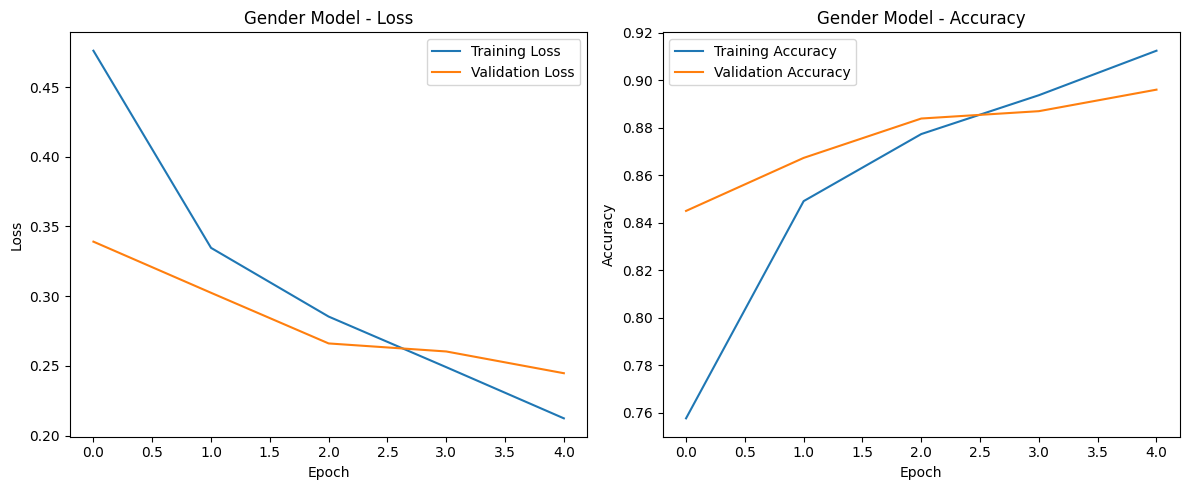

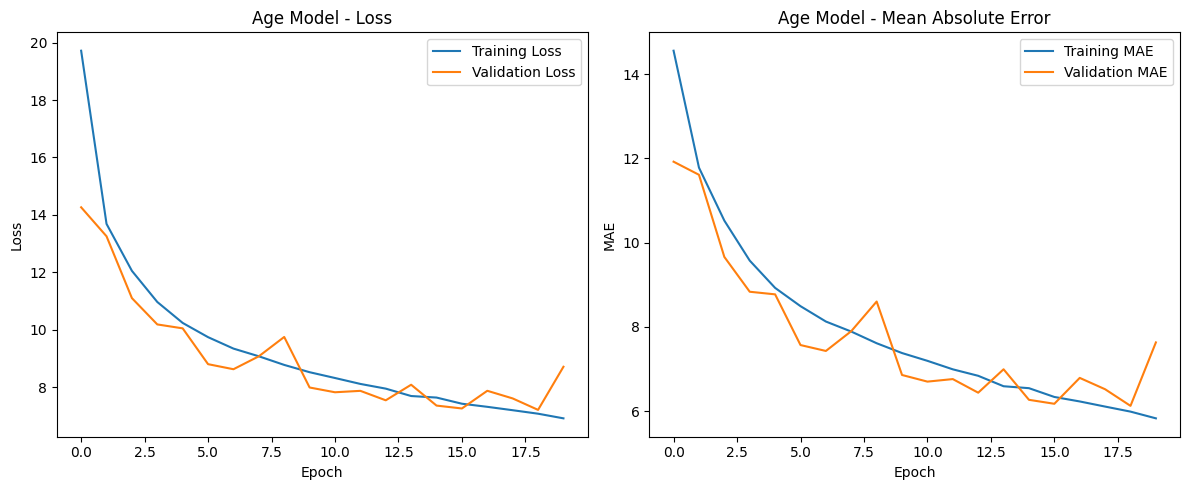

In [22]:
gender_loss = gender_history.history['loss']
gender_val_loss = gender_history.history['val_loss']
gender_accuracy = gender_history.history['accuracy']
gender_val_accuracy = gender_history.history['val_accuracy']

age_loss = age_history.history['loss']
age_val_loss = age_history.history['val_loss']
age_mae = age_history.history['mae']
age_val_mae = age_history.history['val_mae']

# Crea gráficos para el modelo de género
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(gender_loss, label='Training Loss')
plt.plot(gender_val_loss, label='Validation Loss')
plt.title('Gender Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gender_accuracy, label='Training Accuracy')
plt.plot(gender_val_accuracy, label='Validation Accuracy')
plt.title('Gender Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Crea gráficos para el modelo de edad
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(age_loss, label='Training Loss')
plt.plot(age_val_loss, label='Validation Loss')
plt.title('Age Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(age_mae, label='Training MAE')
plt.plot(age_val_mae, label='Validation MAE')
plt.title('Age Model - Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 386ms/step


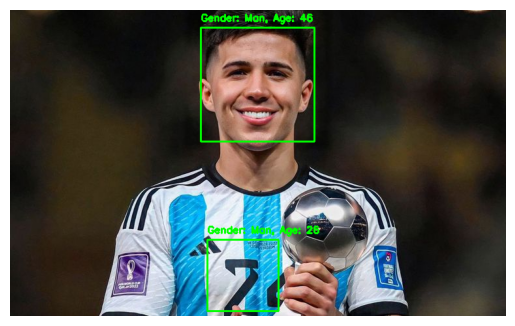

In [78]:
img_path = '/kaggle/input/enzzoo/Enzo-Fernandez.jpg' 
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

for (x, y, w, h) in faces:
    face_roi = img[y:y+h, x:x+w]
    
    face_roi = cv2.resize(face_roi, (224, 224))
    face_roi = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)
    face_roi = face_roi.astype(np.float32) / 255.0

    gender_prediction = gender_model.predict(np.expand_dims(face_roi, axis=0))
    gender_label = "Man" if gender_prediction < 0.5 else "Women"

    age_prediction = age_model.predict(np.expand_dims(face_roi, axis=0))

    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    label = f'Gender: {gender_label}, Age: {int(age_prediction[0][0])}'
    cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
